# KNN tuning number of neighbors

In this notebook we tune the number of neigbors used for optimal prediction of the stock prices.
We build on the findings in `3.1.1-knn_prediction_tuning_features.ipynb`

In [1]:
import matplotlib

from sklearn import neighbors
from sklearn.model_selection import train_test_split
from IPython.display import display

from data.get_50_highest_weights import get_sp_50_highest_weights_symbols
from data_preparation.ochlva_data import OCHLVAData
from utils.column_modifiers import target_generator
from utils.column_modifiers import feature_generator
from utils.column_modifiers import keep_columns
from utils.scorers import normalized_root_mean_square_error
from estimators.predictions import calculate_rolling_prediction

C:\Users\michael.l.magnussen\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
matplotlib.use('nbAgg')

In [3]:
import matplotlib.pyplot as plt
from utils.visualizations import plot_scores
from utils.visualizations import plot_true_and_prediction

Load the S&P 500 (as `^GSPC`) data

In [4]:
ochlva_data = OCHLVAData()

Load three other stocks: The stock weighted the most, the medium weighted stock and the lowest weighted stock (out of the 50 downloaded). 
We do this in order to get a better feeling of the model.

In [5]:
symbols = get_sp_50_highest_weights_symbols()

# Select symbols with high, medium and low weights
selected_symbols = (symbols.iloc[0], 
                    symbols.iloc[len(symbols)//2], 
                    symbols.iloc[-1])

for s in selected_symbols:
    ochlva_data.load_data(s)

For now, we will only be interested in training using the adjusted close values.

In [6]:
# Keep only 'Adj. Close' column
ochlva_data.transform(keep_columns, ['Adj. Close'], copy=False)

Next, we create the target values for the data.
The target columns will be shifted 7, 14 and 28 days with respect to 'Adj. Close'.

In [7]:
days = [7, 14, 28]
ochlva_data.transform(target_generator, 'Adj. Close', days, copy=False)

## Tuning the number of neighbors on the validation set

In order not to leak information of the unseen data into the tuning we will tune the number of neighbors on a validation set.

In [8]:
feature_days = 160
neighbors_list = [1, 2, 3, 4, 5, 10, 20]

validation_scores = dict()
train_scores = dict()

for key in ochlva_data.transformed_data.keys():
    print(f'Processing {key}')
    # Extract the features and targets
    x = ochlva_data.transformed_data[key].\
        loc[:, ochlva_data.transformed_data[key].columns[:-len(days)]] 
    y = ochlva_data.transformed_data[key].\
        loc[:, ochlva_data.transformed_data[key].columns[-len(days):]]
       
    # Append the stock to the scores
    validation_scores[key] = dict()
    train_scores[key] = dict()
    
    for n in neighbors_list:        
        reg = neighbors.KNeighborsRegressor(n_neighbors=n)
        
        x_w_features = feature_generator(x, 'Adj. Close', feature_days,
                                         copy=True)
        
        x_train, _, y_train, y_test = \
            train_test_split(x_w_features, y, shuffle=False, test_size=.2)    
        x_train_for_validate, x_validate, y_train_for_validate, y_validate = \
            train_test_split(x_train, y_train, shuffle=False, test_size=.2)

        # Obtain the day of prediction
        # I.e. for a column named x + 2 days, we would expect the two last rows
        # to contain nan
        prediction_days = y_test.isnull().sum()

        # Calculate validation scores
        y_pred, y_pred_train = \
            calculate_rolling_prediction(reg,
                                         x_train_for_validate,
                                         x_validate,
                                         y_train_for_validate,
                                         y_validate, 
                                         prediction_days,
                                         training_prediction=True)
        validation_scores[key][n] =\
            normalized_root_mean_square_error(y_validate, y_pred)
        
        # The true value of the trainings is the same as y_validate shifted by 
        # one day
        y_train_true = y_train.loc[y_pred_train.index, :] 
        train_scores[key][n] = \
            normalized_root_mean_square_error(y_train_true, y_pred_train)  

Processing ^GSPC
Processing AAPL
Processing CMCSA
Processing GILD


<IPython.core.display.Javascript object>


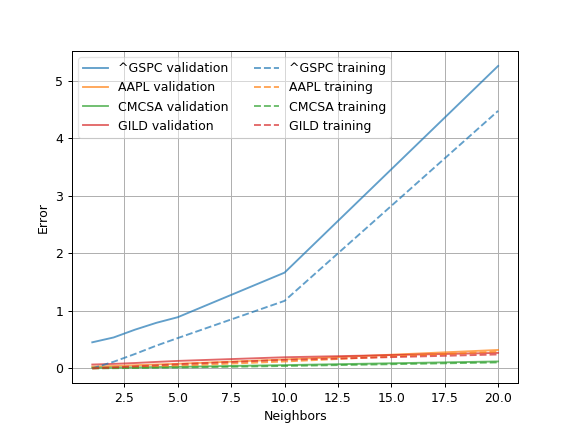

In [9]:
_ = plot_scores(train_scores, validation_scores, x_label='Neighbors')
plt.show()

We can see that both the training and validation error is decreasing as we increase the number of neighbors.
There seem to be no signs of overfitting.

## Test on the unseen test set

We will now test how well the model with the features generalizes on the unseen test set.
This will also act as a sanity check in order to see that what we have found so far is reasonable.

<IPython.core.display.Javascript object>


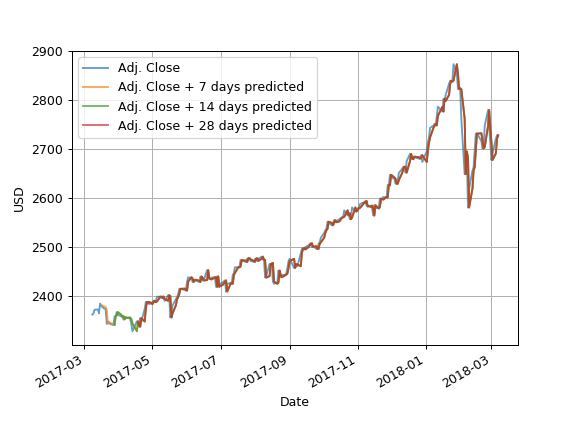

Normalized root mean squared error (averaged for the three predictions): 0.5406772120927225
--------------------------------------------------------------------------------








<IPython.core.display.Javascript object>


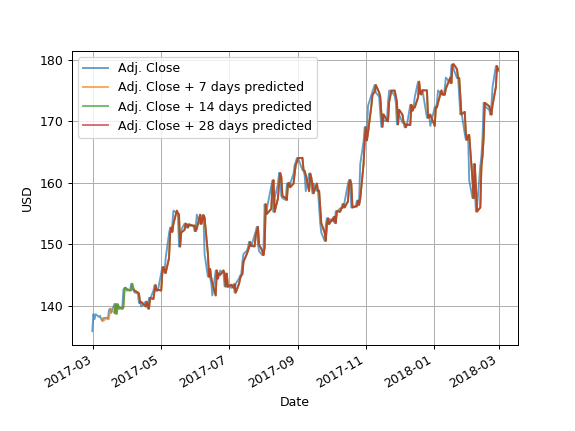

Normalized root mean squared error (averaged for the three predictions): 0.09507740717066897
--------------------------------------------------------------------------------








<IPython.core.display.Javascript object>


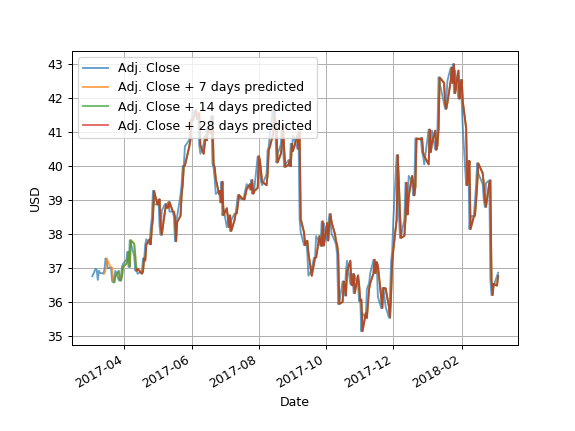

Normalized root mean squared error (averaged for the three predictions): 0.04242860108178018
--------------------------------------------------------------------------------








<IPython.core.display.Javascript object>


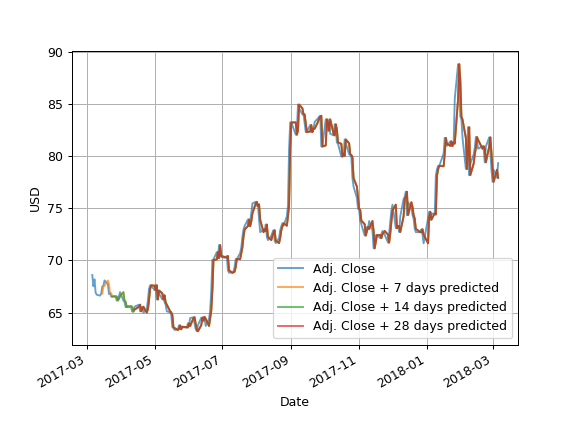

Normalized root mean squared error (averaged for the three predictions): 0.04873277206003287
--------------------------------------------------------------------------------








In [10]:
optimal_n = 1

for key in ochlva_data.transformed_data.keys():
    
    x = ochlva_data.transformed_data[key].\
        loc[:, ochlva_data.transformed_data[key].columns[:-len(days)]] 
    y = ochlva_data.transformed_data[key].\
        loc[:, ochlva_data.transformed_data[key].columns[-len(days):]]
        
    x_w_features = feature_generator(x, 'Adj. Close', feature_days, copy=True)   
    
    x_train, x_test, y_train, y_test = \
        train_test_split(x_w_features, y, shuffle=False, test_size=.2)
    
    # Obtain the day of prediction
    # I.e. for a column named x + 2 days, we would expect the two last rows
    # to contain nan
    prediction_days = y_test.isnull().sum()
    
    # Make the regressor with the optimal n
    reg = neighbors.KNeighborsRegressor(n_neighbors=optimal_n)

    # NOTE: We refit the model here with the same architecture as we used in the
    #       predictions above
    #       However, the data will be different for each time as we do a rolling
    #       prediction
    y_pred = calculate_rolling_prediction(reg,
                                          x_train,
                                          x_test,
                                          y_train,
                                          y_test, 
                                          prediction_days)
    
    # Plot the results
    _ = plot_true_and_prediction(x_test, y_pred, 
                                 columns=['Adj. Close'], y_label='USD')
    plt.show()
    
    # Calculate the normalized root mean squared error
    nrmse = normalized_root_mean_square_error(y_test, y_pred)
    
    print((f'Normalized root mean squared error (averaged for the three '
           f'predictions): {nrmse}'))
    
    print('-'*80)
    print('\n'*5)